In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import json
from pprint import pprint

def save_fig(fig, name):
    fig.savefig("graphs/{}.png".format(name), format="png", dpi=500)
    fig.savefig("graphs/{}.pdf".format(name), format="pdf", dpi=500)

In [2]:
def load_json(path):
    with open(path) as f:
        data = json.load(f)
    
    timings = [];
    for d in data["datapoints"]:
        s = d["setting"]
        time = list(map(lambda x: (x["computationTime"], x['iterationCount'], x["pixelCount"]),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        timings.extend(time)
    
    return timings

/Users/databook/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/Users/databook/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/Users/databook/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/Users/databook/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/Users/databook/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/databook/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


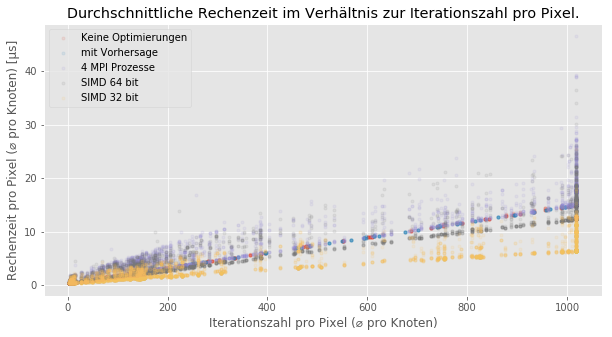

In [3]:
base = load_json("./data/data_sum_base_case.json")
prediction = load_json("./data/data_sum_prediction.json")
mpi = load_json("./data/data_sum_prediction_MPI.json")
simd = load_json("./data/data_sum_prediction_MPI_SIMD.json")
simd32 = load_json("./data/data_sum_prediction_MPI_SIMD_32bit.json")


labels = ["Keine Optimierungen", "mit Vorhersage", "4 MPI Prozesse", "SIMD 64 bit", "SIMD 32 bit"]

base_time, base_it, base_px = zip(*base)
prediction_time, prediction_it, prediction_px = zip(*prediction)
mpi_time, mpi_it, mpi_px = zip(*mpi)
simd_time, simd_it, simd_px = zip(*simd)
simd32_time, simd32_it, simd32_px = zip(*simd32)



data = [
    (np.asarray(base_it)/np.asarray(base_px), (np.asarray(base_time)/np.asarray(base_px))),
    (np.asarray(prediction_it)/np.asarray(prediction_px), (np.asarray(prediction_time)/np.asarray(prediction_px))),
    (np.asarray(mpi_it)/np.asarray(mpi_px), (np.asarray(mpi_time)/np.asarray(mpi_px))),
    (np.asarray(simd_it)/np.asarray(simd_px), (np.asarray(simd_time)/np.asarray(simd_px))),
    (np.asarray(simd32_it)/np.asarray(simd32_px), (np.asarray(simd32_time)/np.asarray(simd32_px)))

]

base_x = np.asarray(base_it)/np.asarray(base_px)
base_time = (np.asarray(base_time)/np.asarray(base_px))

fig, line = plt.subplots(figsize=(10,5))
for i, d in enumerate(data):
    line.plot(d[0], d[1], label=labels[i], lw=0, marker=".", alpha=.1)

line.legend()


line.set(xlabel='Iterationszahl pro Pixel (⌀ pro Knoten)', ylabel='Rechenzeit pro Pixel (⌀ pro Knoten) [µs]',
       title='Durchschnittliche Rechenzeit im Verhältnis zur Iterationszahl pro Pixel.')
line.grid(True)
#line.axis([0, None, 0, 0.04])


# TODO instead: show higher simd overhead => line fit
# plt.yscale('log')
#save_fig(fig, "overall")
plt.show()


In [4]:
def load_json(path):
    with open(path) as f:
        data = json.load(f)
    
    timings = [];
    for d in data["datapoints"]:
        s = d["setting"]
        time = list(map(lambda x: (x["computationTime"], x['mpiTime']),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        timings.extend(time)
    
    return timings

In [5]:
def mean_confidence(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1+ confidence) / 2., n - 1)
    return m, h

base speedup: 1, abs 7.009494
Prediction speedup: 2.759621577782852
4 MPI speedup: 5.055075452988371
4 OpenMP speedup: 7.778871016786263
4 OpenMP + SIMD64 speedup: 9.096812122344733
4 OpenMP + SIMD32 speedup: 7.153683647601047
4 MPI + SIMD32 speedup: 11.59149675050851, abs 0.60471


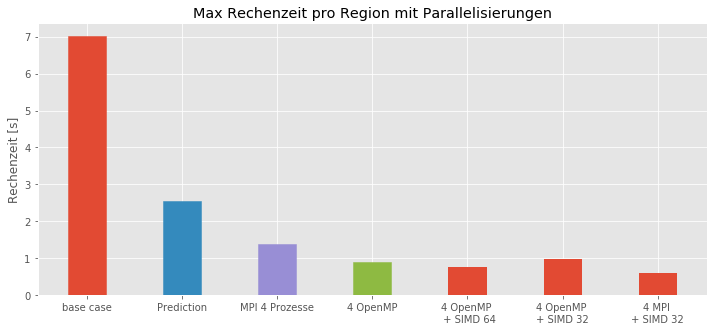

In [10]:
base = load_json("./data/10000/data_sum_base_case.json")
pred = load_json("./data/10000/data_sum_prediction.json")
mpi = load_json("./data/10000/data_sum_prediction_MPI.json")
omp = load_json("./data/10000/data_sum_prediction_OpenMP.json")
simd64 = load_json("./data/10000/data_sum_prediction_OpenMP_SIMD.1.json")
simd32 = load_json("./data/10000/data_sum_prediction_OpenMP_SIMD_32bit.1.json")
simd64.extend(load_json("./data/10000/data_sum_prediction_OpenMP_SIMD.json"))
simd32.extend(load_json("./data/10000/data_sum_prediction_OpenMP_SIMD_32bit.json"))
simd32mpi = load_json("./data/10000/data_sum_prediction_MPI_SIMD_32bit.json")


def stat(data):
    a, b = zip(*data)
    a, b = np.asarray(a) / 1e6, np.asarray(b) / 1e6
    #m, err = mean_confidence(a, .99)
    #m2, err2 = mean_confidence(b, .99)
    #return m, err, m2, err2
    return np.max(a), np.std(a), np.median(b), np.std(b)

base, baseErr, baseMPI, baseMPIErr = stat(base)
pred, predErr, predMPI, predMPIErr = stat(pred)
mpi, mpiErr, mpiMPI, mpiMPIErr = stat(mpi)
omp, ompErr, ompMPI, ompMPIErr = stat(omp)
simd64, simd64Err, simd64MPI, simd64MPIErr = stat(simd64)
simd32, simd32Err, simd32MPI, simd32MPIErr = stat(simd32)
simd32mpi, simd32mpiErr, simd32mpiMPI, simd32mpiMPIErr = stat(simd32mpi)


x_ticks = ["base case", "Prediction", 'MPI 4 Prozesse','4 OpenMP', '4 OpenMP \n + SIMD 64', '4 OpenMP \n+ SIMD 32', '4 MPI \n+ SIMD 32']
x = np.arange(len(x_ticks))
y = (base, pred, mpi, omp, simd64, simd32, simd32mpi)
yerr = (baseErr, predErr, mpiErr, ompErr, simd64Err, simd32Err, simd32mpiErr)


fig, ax = plt.subplots(figsize=(12,5))
total_width = 0.8
ind_width = total_width / 2
alteration = np.arange(-(total_width / 2), total_width/2, ind_width)

barlist = ax.bar(x, y, align='center', width=ind_width)

barlist[0].set_color('#E24A33')
barlist[1].set_color('#348ABD')
barlist[2].set_color('#988ED5')
barlist[3].set_color('#8EBA42')


#yMPI = (baseMPI, predMPI, mpiMPI, ompMPI, simd64MPI, simd32MPI, simd32mpiMPI)
#yMPIErr = (baseMPIErr, predMPIErr, mpiMPIErr, ompMPIErr, simd64MPIErr, simd32MPIErr, simd32mpiMPI)
#ax.bar(alteration[1] + x, yMPI, align='center', color='#FBC15E', width=ind_width, label='Median MPI Zeit')


#ax.errorbar(alteration[0] + x, y, yerr=yerr, color='#555555', ls='none', lw = 2, capthick = 2)
#ax.errorbar(alteration[1] + x, yMPI, yerr=yMPIErr, color='#555555', ls='none', lw = 2, capthick = 2)
ax.set_ylabel('Rechenzeit [s]')
ax.set_title('Max Rechenzeit pro Region mit Parallelisierungen')

ax.set_xticks(np.arange(len(x_ticks)))
ax.set_xticklabels(x_ticks)
#ax.legend()
#plt.yscale('log')
save_fig(fig, 'overall_10000_both')

print("base speedup: {}, abs {}".format(1, base))
print("Prediction speedup: {}".format(base / pred))
print("4 MPI speedup: {}".format(base / mpi))
print("4 OpenMP speedup: {}".format(base / omp))
print("4 OpenMP + SIMD64 speedup: {}".format(base / simd64))
print("4 OpenMP + SIMD32 speedup: {}".format(base / simd32))
print("4 MPI + SIMD32 speedup: {}, abs {}".format(base / simd32mpi, simd32mpi))

plt.show()
